## Recommendation System

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import sklearn.metrics.pairwise as pw
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances

from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
%matplotlib inline

In [2]:
book = pd.read_csv("C:\\Users\\rohit\\OneDrive\\Desktop\\recommdation statments\\book (1).csv", encoding="latin-1")

In [3]:
book.head()

,Unnamed: 0,User.ID,Book.Title,Book.Rating
0,1,276726,Classical Mythology,5
1,2,276729,Clara Callan,3
2,3,276729,Decision in Normandy,6
3,4,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,5,276737,The Mummies of Urumchi,6


In [4]:
book.rename(columns={'Unnamed: 0':'ID'}, inplace=True )
book.rename(columns={'Book.Title':'Title'}, inplace = True)
book.rename(columns={'User.ID':'User'}, inplace = True)
book.rename(columns={'Book.Rating':'Rating'}, inplace = True)

In [5]:
book.shape

(10000, 4)

In [8]:
num_ratings = book['Rating'].count()
num_users = book['ID'].nunique()
num_books = book['Title'].nunique()

pd.DataFrame([['# of Ratings', num_ratings],
            ['# of Users', num_users],
            ['# of Books', num_books]],
            columns = ['Characteristic', 'Count'])

,Characteristic,Count
0,# of Ratings,10000
1,# of Users,10000
2,# of Books,9659


As we can see, there were 10000 rows and 4 columns out of which Rating Count is 10000, Unique Users 2182 & Unique Book title is 9659

# Exploratory Data Analysis :Average Ratings by Users

In [9]:
book.describe()

,ID,User,Rating
count,10000.00000,10000.000000,10000.00000
mean,5000.50000,95321.249800,7.56630
std,2886.89568,117645.703609,1.82152
min,1.00000,8.000000,1.00000
25%,2500.75000,2103.000000,7.00000
50%,5000.50000,3757.000000,8.00000
75%,7500.25000,162052.000000,9.00000
max,10000.00000,278854.000000,10.00000


In [11]:
book['Rating'].describe()

count    10000.00000
mean         7.56630
std          1.82152
min          1.00000
25%          7.00000
50%          8.00000
75%          9.00000
max         10.00000
Name: Rating, dtype: float64

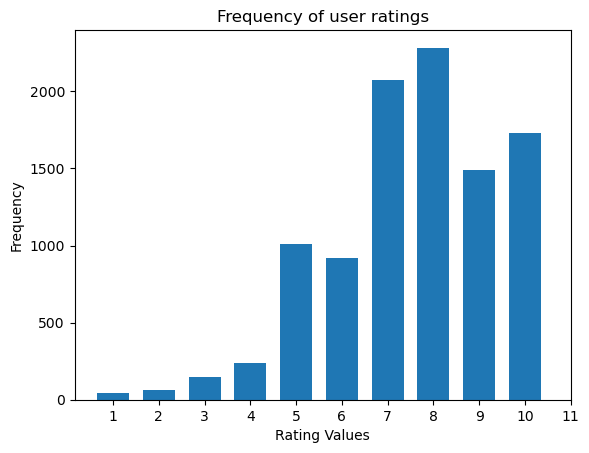

In [12]:
data = book['Rating']
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

plt.hist(data, bins, align="left", rwidth = 0.7)
plt.xticks(bins)
plt.xlabel('Rating Values')
plt.ylabel('Frequency')
plt.title('Frequency of user ratings')
plt.show()

As we see, most users provided pretty positive ratings on books, with the most frequent rating being 8 and average was 7.5

In [13]:
# printing the book tile randomly
book['Title']

0                                     Classical Mythology
1                                            Clara Callan
2                                    Decision in Normandy
3       Flu: The Story of the Great Influenza Pandemic...
4                                  The Mummies of Urumchi
                              ...                        
9995         American Fried: Adventures of a Happy Eater.
9996                                Cannibal In Manhattan
9997                      How to Flirt: A Practical Guide
9998                                             Twilight
9999                         Kids Say the Darndest Things
Name: Title, Length: 10000, dtype: object

# Book Title - Word count distribution

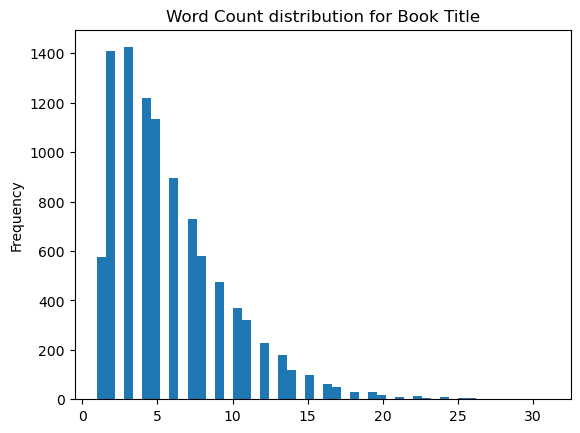

In [14]:
# calculating the word count for book description
book['word_count'] = book['Title'].apply(lambda x: len(str(x).split()))
book['word_count'].plot(kind = 'hist',bins = 50)
plt.title ('Word Count distribution for Book Title')
plt.show()

Recommendation engine

We are going to build two recommendation engines using the book titles

Convert each book title into vectors using TF-IDF and bigram.
2.We are building two recommendation engines, one with a book title. 3. Calculate the similarity between all the books using cosine similarity.

In [15]:
book['Title'].head(20)

0                                   Classical Mythology
1                                          Clara Callan
2                                  Decision in Normandy
3     Flu: The Story of the Great Influenza Pandemic...
4                                The Mummies of Urumchi
5                                The Kitchen God's Wife
6     What If?: The World's Foremost Military Histor...
7                                       PLEADING GUILTY
8     Under the Black Flag: The Romance and the Real...
9               Where You'll Find Me: And Other Stories
10                          Nights Below Station Street
11    Hitler's Secret Bankers: The Myth of Swiss Neu...
12                                   The Middle Stories
13                                             Jane Doe
14    A Second Chicken Soup for the Woman's Soul (Ch...
15         The Witchfinder (Amos Walker Mystery Series)
16    More Cunning Than Man: A Social History of Rat...
17                        Goodbye to the Butterm

In [16]:
rating = pd.DataFrame(book, columns=['ID', 'Title', 'Rating'])
print(rating)

         ID                                              Title  Rating
0         1                                Classical Mythology       5
1         2                                       Clara Callan       3
2         3                               Decision in Normandy       6
3         4  Flu: The Story of the Great Influenza Pandemic...       8
4         5                             The Mummies of Urumchi       6
...     ...                                                ...     ...
9995   9996       American Fried: Adventures of a Happy Eater.       7
9996   9997                              Cannibal In Manhattan       9
9997   9998                    How to Flirt: A Practical Guide       7
9998   9999                                           Twilight       8
9999  10000                       Kids Say the Darndest Things       6

[10000 rows x 3 columns]


In [17]:
print(rating)

         ID                                              Title  Rating
0         1                                Classical Mythology       5
1         2                                       Clara Callan       3
2         3                               Decision in Normandy       6
3         4  Flu: The Story of the Great Influenza Pandemic...       8
4         5                             The Mummies of Urumchi       6
...     ...                                                ...     ...
9995   9996       American Fried: Adventures of a Happy Eater.       7
9996   9997                              Cannibal In Manhattan       9
9997   9998                    How to Flirt: A Practical Guide       7
9998   9999                                           Twilight       8
9999  10000                       Kids Say the Darndest Things       6

[10000 rows x 3 columns]


In [18]:
n_users = rating['ID'].unique().shape[0]
print (n_users)

10000


In [19]:
n_items = rating['Title'].unique().shape[0]
print(n_items)

9659


In [20]:
rating.drop_duplicates(subset= "Title", keep= False, inplace= True)

In [21]:
rating.dtypes

ID         int64
Title     object
Rating     int64
dtype: object

In [22]:
sorted(rating['ID'].unique())

[1,
 2,
 3,
 4,
 5,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 39,
 41,
 43,
 44,
 46,
 47,
 49,
 50,
 51,
 52,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 85,
 86,
 87,
 88,
 89,
 90,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 116,
 117,
 118,
 120,
 121,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 135,
 136,
 137,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 156,
 157,
 158,
 159,
 160,
 161,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 204,
 205,
 206,
 2

In [23]:
sorted(rating['Title'].unique())

[' Jason, Madison &amp',
 ' Other Stories;Merril;1985;McClelland &amp',
 ' Repairing PC Drives &amp',
 "'48",
 "'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities",
 '...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR',
 '01-01-00: A Novel of the Millennium',
 '1,401 More Things That P*Ss Me Off',
 '10 Commandments Of Dating',
 '100 Great Fantasy Short, Short Stories',
 '1001 Brilliant Ways to Checkmate',
 '101 Bright Ideas: Esl Activities for All Ages',
 '101 Dalmatians',
 '101 Essential Tips: House Plants',
 '101 Telephone Jokes',
 '101 Wacky Computer Jokes',
 '101 Ways to Make Money at Home',
 '11 Edward Street',
 '11th Hour',
 '13 99 Euros',
 '14,000 Things to Be Happy About',
 '1984',
 '20 Jahre 40 bleiben. Jung und schÃ?Â¶n in den besten Jahren.',
 '20 Years of Censored News',
 '20,000 Leagues Under the Sea (Wordsworth Collection)',
 '20,001 Names for Baby',
 '2001 Spanish and English Idioms/2001 Modismos Espanoles E Ingleses: 2001 Modismos Espanoles 

In [24]:
sorted(rating['Rating'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [25]:
rating.loc[rating.Rating == 10,:]

,ID,Title,Rating
6,7,What If?: The World's Foremost Military Histor...,10
16,17,More Cunning Than Man: A Social History of Rat...,10
23,24,Mary-Kate &amp; Ashley Switching Goals (Mary-K...,10
24,25,Tell Me This Isn't Happening,10
34,35,Sturmzeit. Roman.,10
...,...,...,...
9958,9959,HOUSE OF MIRTH,10
9967,9968,The Man Who Ate the 747,10
9968,9969,Women of Mystery,10
9969,9970,The Maggody Militia: An Arly Hanks Mystery (Ar...,10


In [26]:
rating.loc[rating.Rating == 1,:]

,ID,Title,Rating
115,116,A Kiss Remembered,1
640,641,Children of the Night,1
1442,1443,Saucer,1
1717,1718,Catechism of the Catholic Church,1
2107,2108,Anam Cara : A Book of Celtic Wisdom,1
2231,2232,The Selfish Gene,1
2294,2295,Having Our Say: The Delany Sisters' First 100 ...,1
2320,2321,"The Elements of Style, Fourth Edition",1
2321,2322,How to Say It Style Guide,1
3900,3901,Fatal Care,1


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


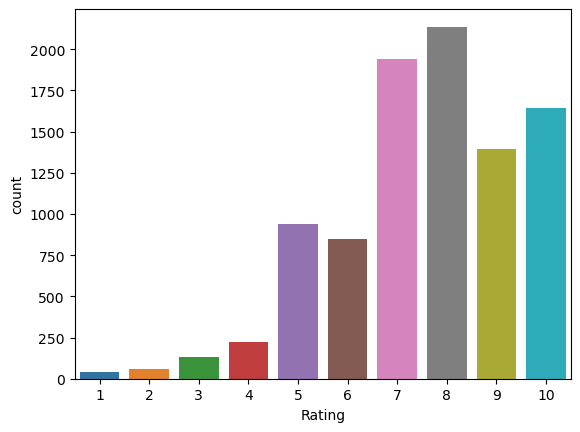

In [27]:
sns.countplot(rating.Rating)
plt.show()

In [28]:
#Segragating implicit and explict ratings datasets
ratings_explicit = rating[rating.Rating != 1]
ratings_implicit = rating[rating.Rating == 8]

In [29]:
ratings_explicit.head()

,ID,Title,Rating
0,1,Classical Mythology,5
1,2,Clara Callan,3
2,3,Decision in Normandy,6
3,4,Flu: The Story of the Great Influenza Pandemic...,8
4,5,The Mummies of Urumchi,6


In [30]:
ratings_implicit.head()

,ID,Title,Rating
3,4,Flu: The Story of the Great Influenza Pandemic...,8
9,10,Where You'll Find Me: And Other Stories,8
13,14,Jane Doe,8
14,15,A Second Chicken Soup for the Woman's Soul (Ch...,8
29,30,OUT OF THE SILENT PLANET,8


In [31]:
print (rating.shape)
print (ratings_explicit.shape)
print (ratings_implicit.shape)

(9354, 3)
(9314, 3)
(2137, 3)


In [32]:
rating[rating.Rating == 1]

,ID,Title,Rating
115,116,A Kiss Remembered,1
640,641,Children of the Night,1
1442,1443,Saucer,1
1717,1718,Catechism of the Catholic Church,1
2107,2108,Anam Cara : A Book of Celtic Wisdom,1
2231,2232,The Selfish Gene,1
2294,2295,Having Our Say: The Delany Sisters' First 100 ...,1
2320,2321,"The Elements of Style, Fourth Edition",1
2321,2322,How to Say It Style Guide,1
3900,3901,Fatal Care,1


In [33]:
rating[rating.Rating == 2]

,ID,Title,Rating
255,256,Thief of Time,2
346,347,Mientras Escribo,2
352,353,Seattle Access,2
379,380,Though I walk through the valley,2
998,999,Meet the Stars of Buffy the Vampire Slayer,2
1328,1329,Uncle Tungsten: Memories of a Chemical Boyhood,2
1489,1490,Faking It,2
1503,1504,With Heart,2
1539,1540,Thing of Beauty,2
1595,1596,The Blue Nowhere : A Novel,2


# Top Rated Books

In [34]:
g = ratings_explicit.groupby(ratings_explicit.Title)['Rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_books[:10]

array([' Jason, Madison &amp', 'Sophisticated Lady (Loveswept #379)',
       'Spanking Watson (Kinky Friedman Novels (Paperback))',
       "Sparks of Genius: The Thirteen Thinking Tools of the World's Most Creative People",
       'Speak', 'Speaker of Mandarin', 'Speaking In Tongues : A Novel',
       'Speaking With the Angel',
       'Speaks the Nightbird, Volume I : Judgment of the Witch',
       'Special Circumstances: A Novel'], dtype=object)

In [35]:
userRatesPerBookCount = rating.groupby(['ID', 'Title'], as_index = False).count().sort_values('Rating', ascending = False)
userRatesPerBookCount.head(15)

,ID,Title,Rating
0,1,Classical Mythology,1
6247,6736,Patience of a Saint,1
6231,6719,Second Ring of Power,1
6232,6720,Precious Victims,1
6233,6721,Mother on Trial: The Mysterious Death of an Ou...,1
6234,6723,Making Woman Surgeon,1
6235,6724,The Associate,1
6236,6725,"Special Effects (Family, Bk 1)",1
6237,6726,Blackout,1
6238,6727,The Image,1


In [36]:
userRatesPerBookCount.tail(15)

,ID,Title,Rating
3109,3412,The Root Cellar,1
3110,3413,AixÃ² Ã©s RÃ dio Pica (ColÂ¨lecciÃ³ Embat),1
3111,3415,Dress Your Family in Corduroy and Denim,1
3112,3416,"Ransom (Steel, Danielle)",1
3113,3418,"I, Robot",1
3114,3419,Drinking Coffee Elsewhere (Today Show Book Clu...,1
3116,3421,The Husband Test,1
3123,3428,Hornet's Nest,1
3117,3422,Summer,1
3118,3423,The Fourth K,1


In [37]:
# Here I calculate the rating mean per user and book, so that I can later replace the mean to the rating value
# and get rid of the duplicates rows

userRatesPerBookMean = rating.groupby(['ID', 'Title'], as_index = False).mean().round(0).sort_values('Rating', ascending = False)
userRatesPerBookMean.head(15)

,ID,Title,Rating
7288,7824,"Absalom, Absalom!: The Corrected Text (Vintage...",10.0
1530,1714,The Cat Who Played Brahms,10.0
4325,4725,Firefox Down,10.0
8916,9532,Swell Foop (Xanth),10.0
4331,4732,Plantation: A Lowcountry Tale,10.0
4332,4733,God Is No Laughing Matter: Observations and Ob...,10.0
4334,4735,Pilgrim Souls : A Collection of Spiritual Auto...,10.0
4335,4736,All You Really Need to Know about Prayer You C...,10.0
4336,4737,The Red Hat Society(TM) : Fun and Friendship A...,10.0
4337,4738,Wild Man's Journey: Reflections on Male Spirit...,10.0


In [38]:
# We create now a table grouped by user and book pair, calculating mean and number of rating that a user has made for the
# same book

rating['count'] = rating['Rating']

userRatesPerBook = rating.groupby(['ID', 'Title'], as_index = False) \
                   .agg({'Rating' : 'mean', 'count' : 'count'}) \
                   .rename(columns = {'Rating':'mean'}) \
                   .sort_values('count', ascending = False)

ratings = rating.drop(['count'], axis = 1)
            
userRatesPerBook['mean'] = userRatesPerBook['mean'].round(0)
userRatesPerBook.head()

,ID,Title,mean,count
0,1,Classical Mythology,5.0,1
6247,6736,Patience of a Saint,4.0,1
6231,6719,Second Ring of Power,4.0,1
6232,6720,Precious Victims,10.0,1
6233,6721,Mother on Trial: The Mysterious Death of an Ou...,7.0,1


In [39]:
# Now I append the mean and count per each user and book to the ratings table:

ratings = pd.merge(rating, userRatesPerBook, on = ['ID', 'Title'])
ratings.head()

,ID,Title,Rating,count_x,mean,count_y
0,1,Classical Mythology,5,5,5.0,1
1,2,Clara Callan,3,3,3.0,1
2,3,Decision in Normandy,6,6,6.0,1
3,4,Flu: The Story of the Great Influenza Pandemic...,8,8,8.0,1
4,5,The Mummies of Urumchi,6,6,6.0,1


In [40]:
rating.sort_values('count', ascending = False).head(15)

,ID,Title,Rating,count
7823,7824,"Absalom, Absalom!: The Corrected Text (Vintage...",10,10
1713,1714,The Cat Who Played Brahms,10,10
4724,4725,Firefox Down,10,10
9531,9532,Swell Foop (Xanth),10,10
4731,4732,Plantation: A Lowcountry Tale,10,10
4732,4733,God Is No Laughing Matter: Observations and Ob...,10,10
4734,4735,Pilgrim Souls : A Collection of Spiritual Auto...,10,10
4735,4736,All You Really Need to Know about Prayer You C...,10,10
4736,4737,The Red Hat Society(TM) : Fun and Friendship A...,10,10
4737,4738,Wild Man's Journey: Reflections on Male Spirit...,10,10


In [41]:
rating.shape

(9354, 4)

In [42]:
# We can now drop the duplicates records for the combination user/book with more than 1 rating

ratings = rating.drop_duplicates(subset = ['Title', 'ID'], keep = 'first', inplace = False)\
                                  .sort_values('count', ascending = False)

In [43]:
ratings = rating.drop(['count'], axis = 1)
ratings.head()

,ID,Title,Rating
0,1,Classical Mythology,5
1,2,Clara Callan,3
2,3,Decision in Normandy,6
3,4,Flu: The Story of the Great Influenza Pandemic...,8
4,5,The Mummies of Urumchi,6


With the purpose of making more relevant recommendations, let's have a look at what is the ratings distribution per users: in other words, let's see if there are users who have rated very few books.

Recommendation Based on Rating Counts

In [44]:
book.groupby('Title').mean().head()

,ID,User,Rating,word_count
Title,,,,
"Jason, Madison &amp",4905.0,2106.0,8.0,3.0
Other Stories;Merril;1985;McClelland &amp,4907.0,2106.0,6.0,3.0
Repairing PC Drives &amp,4906.0,2106.0,4.0,4.0
'48,4405.0,1805.0,7.0,1.0
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,9231.0,161737.0,8.0,11.0


In [45]:
print(book["Title"].isnull().sum() )
print(book["Rating"].isnull().sum() )

0
0


In [46]:
n_users = book['User'].nunique()
n_books = book['Title'].nunique()

print('Num. of Users: '+ str(n_users))
print('Num of Books: '+str(n_books))

Num. of Users: 2182
Num of Books: 9659


In [47]:
book.groupby('Rating').mean()

,ID,User,word_count
Rating,,,
1,5523.209302,82598.906977,5.232558
2,4911.476190,122724.746032,5.920635
3,4758.897260,110713.438356,5.863014
4,4914.270042,114933.189873,5.987342
5,4891.099305,109836.636544,5.583913
6,5042.135870,94575.890217,5.871739
7,5170.971580,86765.114644,5.940270
8,4939.773982,99391.067893,5.663163
9,4891.517749,95875.471534,5.831882


In [48]:
book.groupby('Title')['Rating'].mean().sort_values(ascending=False).head()

Title
Dr Mommy (From Here To Maternity) (Silhouette Desire, 1269)                                                           10.0
The Piano Man's Daughter                                                                                              10.0
Private Screening                                                                                                     10.0
The Pilates Body: The Ultimate At-Home Guide to Strengthening, Lengthening, and Toning Your Body--Without Machines    10.0
Desert Solitaire                                                                                                      10.0
Name: Rating, dtype: float64

In [49]:
book.groupby('Title')['Rating'].count().sort_values(ascending=False).head()

Title
Fahrenheit 451                                   5
Ender's Game (Ender Wiggins Saga (Paperback))    4
Stardust                                         4
Vanished                                         4
Charlie and the Chocolate Factory                4
Name: Rating, dtype: int64

In [50]:
ratings = pd.DataFrame(book.groupby('Title')['Rating'].mean())
ratings.head()

,Rating
Title,
"Jason, Madison &amp",8.0
Other Stories;Merril;1985;McClelland &amp,6.0
Repairing PC Drives &amp,4.0
'48,7.0
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,8.0


In [51]:
ratings['num of ratings'] = pd.DataFrame(book.groupby('Title')['Rating'].count())
ratings

,Rating,num of ratings
Title,,
"Jason, Madison &amp",8.0,1
Other Stories;Merril;1985;McClelland &amp,6.0,1
Repairing PC Drives &amp,4.0,1
'48,7.0,1
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,8.0,1
...,...,...
"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character",8.0,1
"\Well, there's your problem\: Cartoons",9.0,1
iI Paradiso Degli Orchi,7.0,1


<AxesSubplot:>

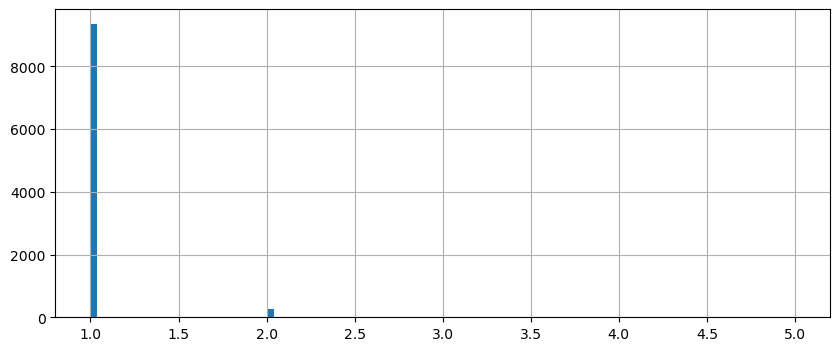

In [52]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=100)

<AxesSubplot:>

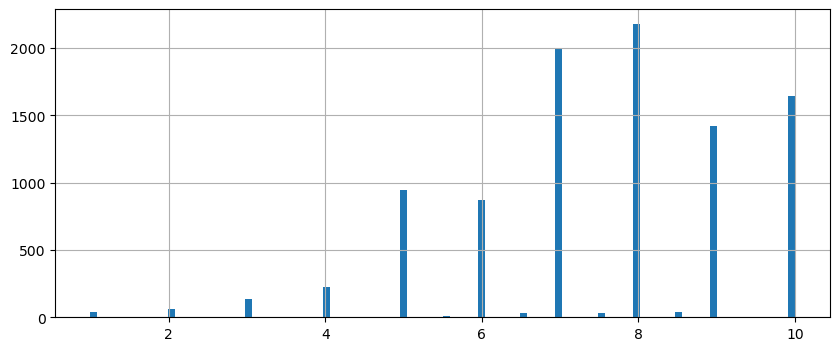

In [53]:
plt.figure(figsize=(10,4))
ratings['Rating'].hist(bins=100)

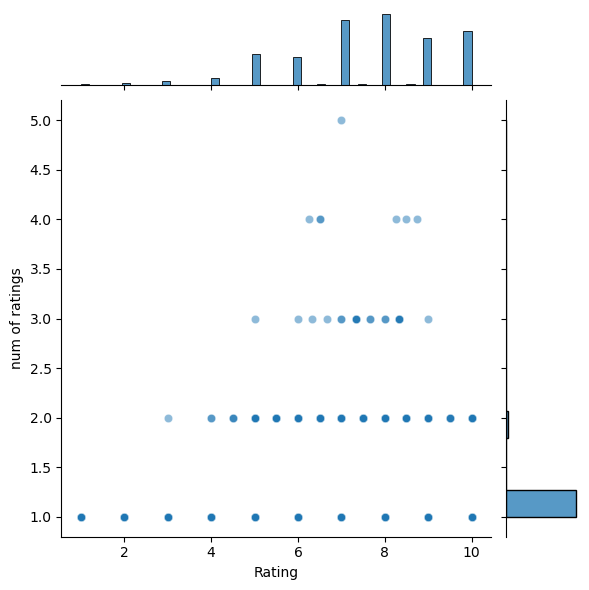

In [54]:
sns.jointplot(x='Rating',y='num of ratings',data=ratings,alpha=0.5)

In [55]:
tfid = TfidfVectorizer(stop_words="english")
tfid_matrix = tfid.fit_transform(book['Title'])
tfid_matrix.shape

(10000, 11435)

In [56]:
print(tfid_matrix)

  (0, 6968)	0.6798989461050784
  (0, 2262)	0.733305818254024
  (1, 1816)	0.7071067811865476
  (1, 2252)	0.7071067811865476
  (2, 7166)	0.6625534369282937
  (2, 2933)	0.749014648197554
  (3, 1996)	0.37362521359059986
  (3, 10886)	0.37362521359059986
  (3, 9021)	0.2813160805754238
  (3, 114)	0.35770766385737696
  (3, 7472)	0.37362521359059986
  (3, 5322)	0.37362521359059986
  (3, 4613)	0.23030946840620475
  (3, 9756)	0.2046583436772717
  (3, 4139)	0.37362521359059986
  (4, 10725)	0.7071067811865476
  (4, 6925)	0.7071067811865476
  (5, 11133)	0.5741118863839041
  (5, 4529)	0.5301064251194945
  (5, 5774)	0.6240053845598971
  (6, 5246)	0.4702119328617262
  (6, 5006)	0.4911357837677152
  (6, 6677)	0.4702119328617262
  (6, 4187)	0.4911357837677152
  (6, 11266)	0.27454099911420016
  :	:
  (9993, 7493)	0.7043514860336613
  (9994, 9700)	0.4171831630623902
  (9994, 11276)	0.37701826971292507
  (9994, 10486)	0.39940991461887054
  (9994, 11295)	0.3162511319165422
  (9994, 6108)	0.34663470081473363


In [57]:
print(tfid.vocabulary_)

{'classical': 2262, 'mythology': 6968, 'clara': 2252, 'callan': 1816, 'decision': 2933, 'normandy': 7166, 'flu': 4139, 'story': 9756, 'great': 4613, 'influenza': 5322, 'pandemic': 7472, '1918': 114, 'search': 9021, 'virus': 10886, 'caused': 1996, 'mummies': 6925, 'urumchi': 10725, 'kitchen': 5774, 'god': 4529, 'wife': 11133, 'world': 11266, 'foremost': 4187, 'military': 6677, 'historians': 5006, 'imagine': 5246, 'pleading': 7844, 'guilty': 4698, 'black': 1425, 'flag': 4095, 'romance': 8685, 'reality': 8350, 'life': 6054, 'pirates': 7793, 'll': 6121, 'stories': 9752, 'nights': 7117, 'station': 9696, 'street': 9784, 'hitler': 5017, 'secret': 9034, 'bankers': 1179, 'myth': 6965, 'swiss': 9965, 'neutrality': 7070, 'holocaust': 5047, 'middle': 6655, 'jane': 5505, 'doe': 3214, 'second': 9032, 'chicken': 2138, 'soup': 9523, 'woman': 11231, 'soul': 9516, 'series': 9113, 'witchfinder': 11204, 'amos': 758, 'walker': 10965, 'mystery': 6961, 'cunning': 2767, 'man': 6341, 'social': 9444, 'history':

In [58]:
# Computing the cosine similarity on Tfidf matrix
cos_sim_matrix = linear_kernel(tfid_matrix,tfid_matrix)
print(cos_sim_matrix)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [59]:
# creating a mapping of anime name to index number 
book_index = pd.Series(book.index,index=book['Title']).drop_duplicates()
print(book_index)

Title
Classical Mythology                                                                                      0
Clara Callan                                                                                             1
Decision in Normandy                                                                                     2
Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It       3
The Mummies of Urumchi                                                                                   4
                                                                                                      ... 
American Fried: Adventures of a Happy Eater.                                                          9995
Cannibal In Manhattan                                                                                 9996
How to Flirt: A Practical Guide                                                                       9997
Twilight                       

In [60]:
book.duplicated(["User","Title", "Rating"]).sum()

2

In [61]:
book_index["Cannibal In Manhattan"]

9996

In [62]:
split_value = int(len(book) * 0.80)
train_data = book[:split_value]
test_data = book[split_value:]

In [63]:
print(train_data.shape)
print(test_data.shape)

(8000, 5)
(2000, 5)


C:\Users\Saurabh\AppData\Local\Temp\ipykernel_19632\424234587.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


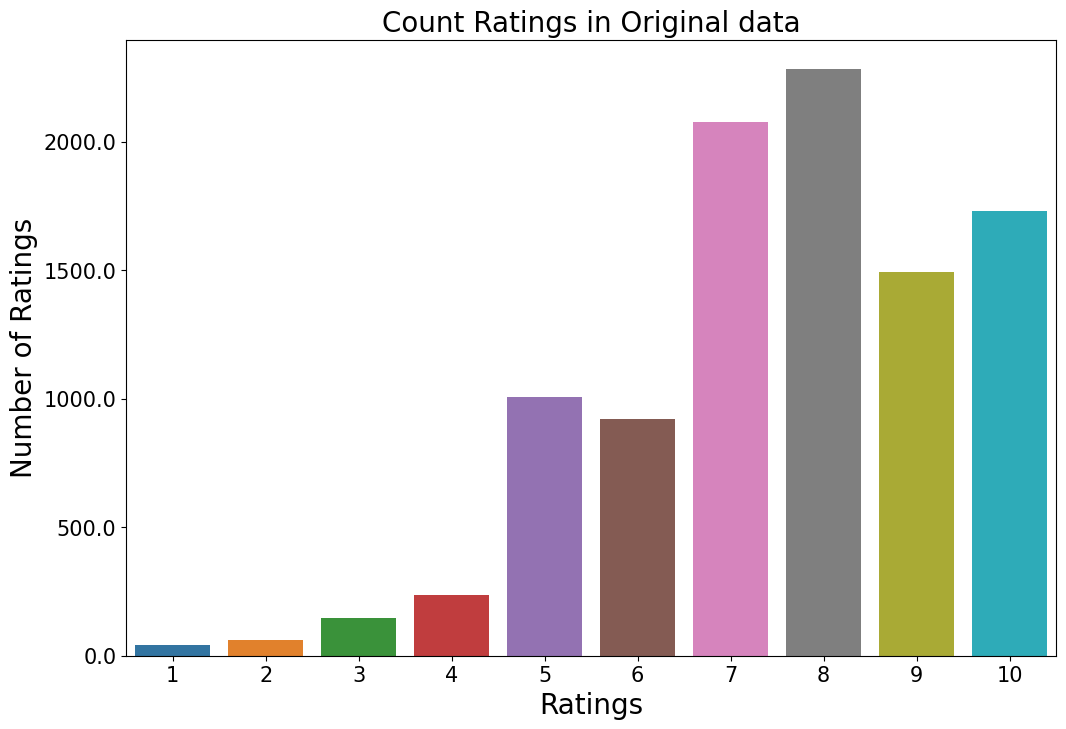

In [64]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="Rating", data=book)
ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Count Ratings in Original data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

C:\Users\Saurabh\AppData\Local\Temp\ipykernel_19632\1249364189.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


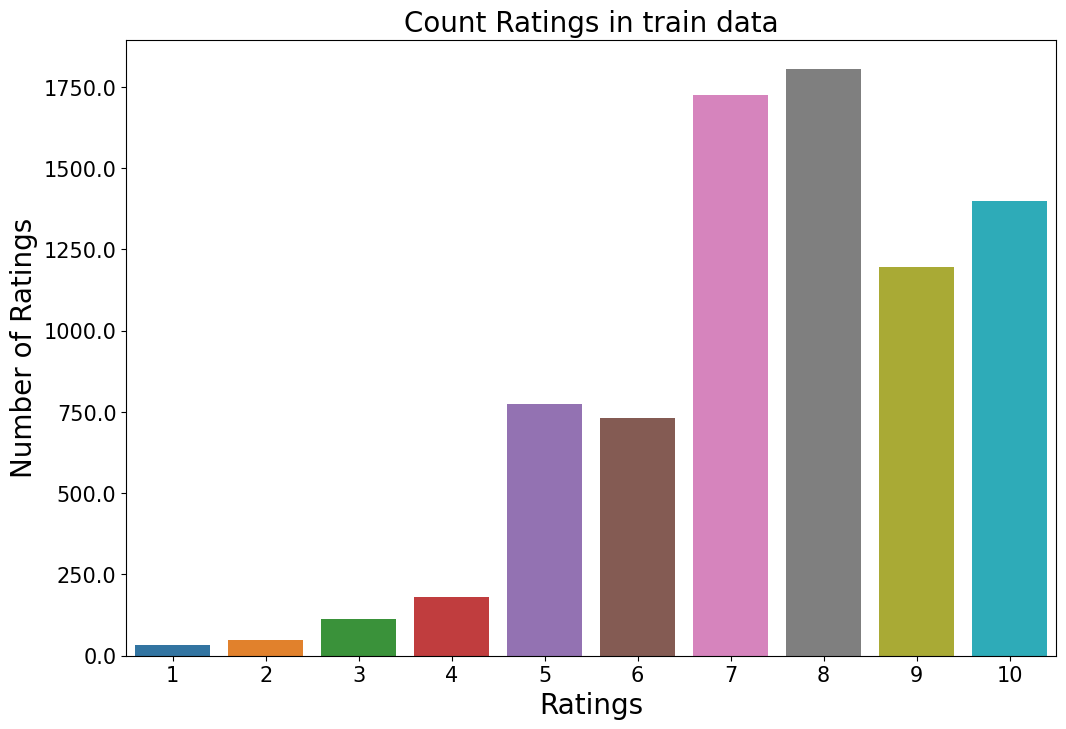

In [65]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="Rating", data=train_data)
ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [66]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df[:,1], (df[:,3], df[:,2])))
    return sparse_data

In [67]:
def get_book_recommendations(Title,topN):
      #topN = 10
    # Getting the book index using its title 
    book_id = book_index[Title]
    # Getting the pair wise similarity score for all the book's 
    #print(book_id)
    cosine_scores = list(enumerate(cos_sim_matrix[book_id]))  
    # Sorting the cosine_similarity scores based on scores 
    cosine_scores = sorted(cosine_scores,key=lambda x:x[1],reverse = True)
    #print(cosine_scores)
    # Get the scores of top 10 most similar books
    cosine_scores_10 = cosine_scores[0:topN+1] 
    #print(cosine_scores_10)
    # Getting the book index 
    book_idx  =  [i[0] for i in cosine_scores_10]
    rat_scores =  [i[1] for i in cosine_scores_10]
    # Similar book and scores
    similar_books = pd.DataFrame(columns=["Title","Rating"])
    similar_books["Title"] = book.loc[book_idx,"Title"]
    similar_books["Rating"] = rat_scores
    print (similar_books)
    similar_books.reset_index(inplace=True)  
    similar_books.drop(["Title"],axis=1,inplace=True)
    #print (similar_books)

In [68]:
get_book_recommendations('Decision in Normandy',topN=2)

                                                  Title    Rating
2                                  Decision in Normandy  1.000000
3560          Currahee!:  A Screaming Eagle at Normandy  0.318337
3559  If You Survive: From Normandy to the Battle of...  0.209653


In [69]:
get_book_recommendations('Kids Say the Darndest Things',topN=5)

                                                  Title    Rating
9999                       Kids Say the Darndest Things  1.000000
8717                               Before I Say Goodbye  0.319959
8865                                     Say No to Joe?  0.319959
2321                          How to Say It Style Guide  0.293177
136                               Before I Say Good-Bye  0.272421
5474  Everything Cat: What Kids Really Want to Know ...  0.267615


In [70]:
get_book_recommendations('Before I Say Good-Bye',topN=20)

                                                  Title    Rating
136                               Before I Say Good-Bye  1.000000
1679                    Before I Say Good-Bye : A Novel  0.955136
1456  Bye, Bye, Butterfree (Pokemon Adventure (Golde...  0.478495
2544                                     How to Be Good  0.467538
7846                                  When She Was Good  0.467538
9140                                            So Good  0.467538
8717                               Before I Say Goodbye  0.377568
8865                                     Say No to Joe?  0.377568
9748                                      The Good Life  0.365183
2321                          How to Say It Style Guide  0.345964
3720                                Too Good to Be True  0.333519
8175                   You Can't Keep a Good Woman Down  0.333119
2944                                         GOOD EARTH  0.323719
6986                                         GOOD EARTH  0.323719
7475      

In [71]:
book.head()

,ID,User,Title,Rating,word_count
0,1,276726,Classical Mythology,5,2
1,2,276729,Clara Callan,3,2
2,3,276729,Decision in Normandy,6,3
3,4,276736,Flu: The Story of the Great Influenza Pandemic...,8,19
4,5,276737,The Mummies of Urumchi,6,4


In [72]:
user_book_rating = book.pivot_table(columns='Title', values='Rating')
user_book_rating

Title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
Rating,8.0,6.0,4.0,7.0,8.0,7.0,10.0,10.0,7.0,10.0,...,8.0,9.0,10.0,7.0,8.0,8.0,9.0,7.0,5.0,4.0


In [73]:
gump_ratings = user_book_rating['Good in Bed']

In [74]:
gump_ratings.head()

Rating    7.0
Name: Good in Bed, dtype: float64

In [75]:
books_like_gump = user_book_rating.corrwith(gump_ratings)
corr_gump = pd.DataFrame(books_like_gump, columns=['Correlation'])
corr_gump.dropna(inplace=True)
corr_gump.head()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation
Title,


In [76]:
corr_gump.sort_values('Correlation', ascending=False).head(10)

,Correlation
Title,


In [77]:
corr_gump_mean = corr_gump.join(ratings['num of ratings'])
corr_gump_mean.head()

,Correlation,num of ratings
Title,,


In [78]:
corr_gump_mean[corr_gump_mean ['num of ratings']>50].sort_values('Correlation', ascending=False).head()

,Correlation,num of ratings
Title,,
